# Alpha-Beta seperately

Our previous model trained on the entire dataset (with both alpha and beta). Now we will train two models, one for alpha and one for beta. This will give us two prediction, which we will then average to get the final prediction.

In [24]:
# andere baseline? Beta en alpha keten nu. Als baseline: 2 modellen: eentje voor beta, eentje voor alfa. Beta trainen op alpha keten, alfa
# baseline beter werken dan clf met enkel alfa of beta? of model trainen op

# nieuwe preprint: nieuwe benchmark dataset. Pieter zet op Slack.

In [25]:
from util import get_train_dataset, get_features, fix_test, plot_roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging
train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)  # contains both alfa and beta features
y = train['reaction']

# Keep only the columns starting with 'alpha_'
x_alpha = x[x.columns[x.columns.str.startswith('alfa_')]]
x_beta = x[x.columns[x.columns.str.startswith('beta_')]]

x_test = get_features(test, test=True) # Note: Without the test=True, I'm still getting the almost perfect prediciton error
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alfa_')]]
x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta_')]]

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0


Try a random forest classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Random forest doesn't support NaN values
x_alpha = x_alpha.fillna(0)
x_beta = x_beta.fillna(0)
x_test_alpha = x_test_alpha.fillna(0)
x_test_beta = x_test_beta.fillna(0)

clf_alpha = RandomForestClassifier(n_estimators=200, random_state=42)
clf_beta = RandomForestClassifier(n_estimators=200, random_state=42)

In [27]:
clf_alpha.fit(x_alpha, y)
clf_beta.fit(x_beta, y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
y_pred_alpha = clf_alpha.predict_proba(x_test_alpha)[:, 1]
y_pred_beta = clf_beta.predict_proba(x_test_beta)[:, 1]

In [30]:
from sklearn import metrics

def calculate_auc_and_plot(y_test, y_pred):

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    plot_roc_curve(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})', title='ROC curve')

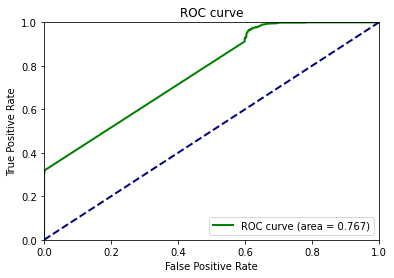

In [44]:
# Calculate AUC for alpha
calculate_auc_and_plot(y_test, y_pred_alpha)

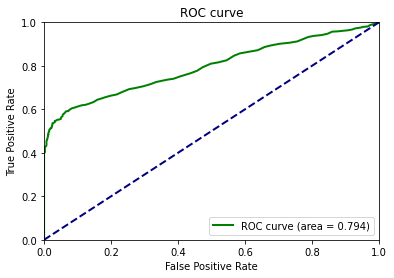

In [45]:
# Calculate AUC for beta
calculate_auc_and_plot(y_test, y_pred_beta)

In [ ]:
y_pred = (y_pred_alpha + y_pred_beta) / 2

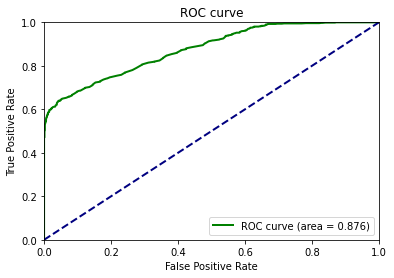

In [31]:
calculate_auc_and_plot(y_test, y_pred)

In [32]:
# y_pred is predicted using predict_proba, so we need to convert it to 0/1
y_pred_label = (y_pred > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_label))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       841
           1       0.96      0.61      0.74       821

    accuracy                           0.79      1662
   macro avg       0.84      0.79      0.78      1662
weighted avg       0.84      0.79      0.79      1662

[[821  20]
 [324 497]]


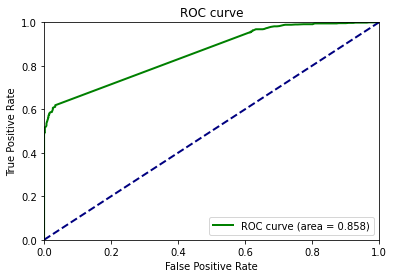

In [33]:
# Instead of averaging the predictions, we can also take the maximum or minimum
import numpy as np
y_pred_max = np.maximum(y_pred_alpha, y_pred_beta)

calculate_auc_and_plot(y_test, y_pred_max)


In [34]:
y_pred_max_label = (y_pred_max > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_max_label))
print(metrics.confusion_matrix(y_test, y_pred_max_label))

              precision    recall  f1-score   support

           0       0.89      0.39      0.54       841
           1       0.60      0.95      0.74       821

    accuracy                           0.67      1662
   macro avg       0.75      0.67      0.64      1662
weighted avg       0.75      0.67      0.64      1662

[[327 514]
 [ 39 782]]


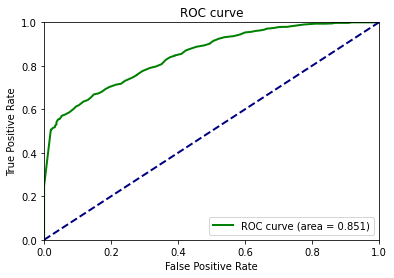

In [35]:
# Or the minimum
y_pred_min = np.minimum(y_pred_alpha, y_pred_beta)

calculate_auc_and_plot(y_test, y_pred_min)

In [36]:
y_pred_min_label = (y_pred_min > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_min_label))
print(metrics.confusion_matrix(y_test, y_pred_min_label))

              precision    recall  f1-score   support

           0       0.67      0.98      0.80       841
           1       0.96      0.51      0.66       821

    accuracy                           0.75      1662
   macro avg       0.82      0.74      0.73      1662
weighted avg       0.81      0.75      0.73      1662

[[824  17]
 [405 416]]


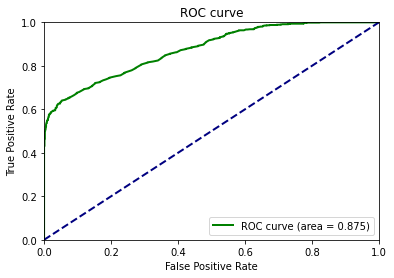

In [37]:
# Or the product
y_pred_product = y_pred_alpha * y_pred_beta

calculate_auc_and_plot(y_test, y_pred_product)

In [46]:
y_pred_product_label = (y_pred_product > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_product_label))
print(metrics.confusion_matrix(y_test, y_pred_product_label))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       841
           1       1.00      0.22      0.37       821

    accuracy                           0.62      1662
   macro avg       0.78      0.61      0.55      1662
weighted avg       0.78      0.62      0.55      1662

[[841   0]
 [637 184]]


Product and average seem to perform the best, yielding a similar result as the model trained on the entire dataset. (and better than the model trained on only alpha or beta).

# Complete only
I'm interested now in how the missing values affects those predictions. Let's see what happens if we remove the rows with missing values.

In [77]:
from util import get_train_dataset, get_features, fix_test, plot_roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

df_length = len(df)
df = df.dropna() # Must be here and not after the get_features, since get_features might also introduce NaN values
print(f'Number of rows removed: {df_length - len(df)} ({(df_length - len(df)) / df_length * 100:.2f}%)')

train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)  # contains both alfa and beta features
y = train['reaction']

# Keep only the columns starting with 'alpha_'
x_alpha = x[x.columns[x.columns.str.startswith('alfa_')]]
x_beta = x[x.columns[x.columns.str.startswith('beta_')]]

x_test = get_features(test, test=True) # Note: Without the test=True, I'm still getting the almost perfect prediciton error
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alfa_')]]
x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta_')]]

Number of rows removed: 4841 (58.28%)


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0


In [78]:
# Remove NaN's introduced by get_features
x_alpha = x_alpha.fillna(0)
x_beta = x_beta.fillna(0)
x_test_alpha = x_test_alpha.fillna(0)
x_test_beta = x_test_beta.fillna(0)

In [79]:
from sklearn.ensemble import RandomForestClassifier

clf_alpha = RandomForestClassifier(n_estimators=200, random_state=42)
clf_beta = RandomForestClassifier(n_estimators=200, random_state=42)

In [80]:
clf_alpha.fit(x_alpha, y)
clf_beta.fit(x_beta, y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [81]:
y_pred_alpha = clf_alpha.predict_proba(x_test_alpha)[:, 1]
y_pred_beta = clf_beta.predict_proba(x_test_beta)[:, 1]

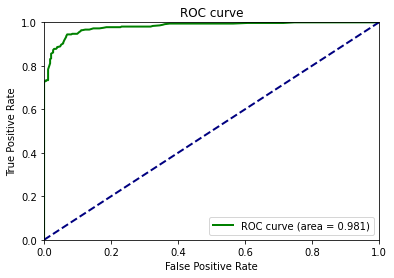

In [82]:
calculate_auc_and_plot(y_test, y_pred_alpha)

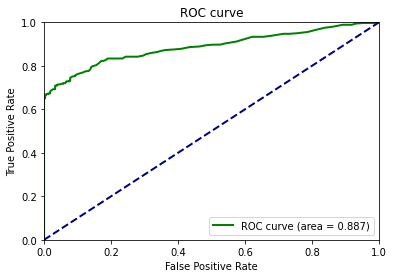

In [83]:
calculate_auc_and_plot(y_test, y_pred_beta)

In [84]:
y_pred = (y_pred_alpha + y_pred_beta) / 2

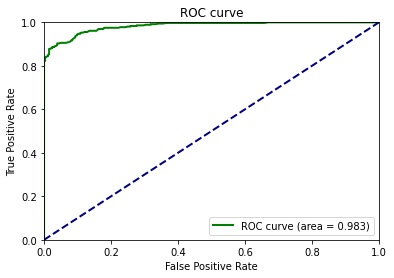

In [85]:
calculate_auc_and_plot(y_test, y_pred)

In [86]:
y_pred_label = (y_pred > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_label))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       333
           1       1.00      0.80      0.89       361

    accuracy                           0.90       694
   macro avg       0.91      0.90      0.90       694
weighted avg       0.91      0.90      0.90       694

[[333   0]
 [ 72 289]]


Alpha tells us more than beta here.